In [62]:
import random
import itertools

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

from coremdlr.datasets import utils as dataset_utils
from coremdlr.config.defaults import DEFAULT_TRAIN_PATH
from coremdlr.config.strip_config import facies

In [5]:
well_names = dataset_utils.available_wells()
well_names

{'204-19-3A',
 '204-19-6',
 '204-19-7',
 '204-20-1',
 '204-20-1Z',
 '204-20-2',
 '204-20-3',
 '204-20-6a',
 '204-20a-7',
 '204-24a-6',
 '204-24a-7',
 '205-21b-3'}

In [39]:
label_names = np.array(list(facies.keys()), dtype='a2').tolist()


label_full_names =['sandstone', 'clay-prone sand', 'sandy mudstone', 'oilstained sand', 'mudstone']
label_colors = ['yellow', 'greenyellow', 'darkseagreen', 'brown', 'darkgray']
label_hatches = ['.', '--', '---', '/', '-']


def get_labels_array(well_name, train_only=False):
    labels = np.load(DEFAULT_TRAIN_PATH / (well_name + '_labels.npy'))
    labels = np.vectorize(lambda l: label_names.index(l))(labels)
    return labels[np.where(labels > 1)] if train_only else labels

def get_total_depth(well_name):
    depths = np.load(DEFAULT_TRAIN_PATH / (well_name + '_depth.npy'))
    return np.median(np.diff(depths)) * depths.size

In [35]:
well_names = list(sorted(well_names, key=lambda w: get_total_depth(w), reverse=True))

total_depth = sum(map(lambda w: get_total_depth(w), well_names))

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


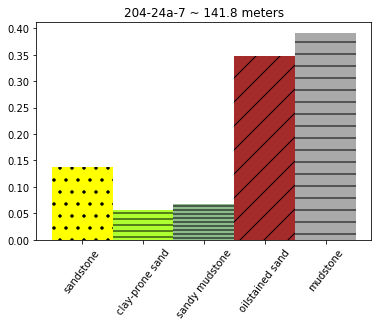

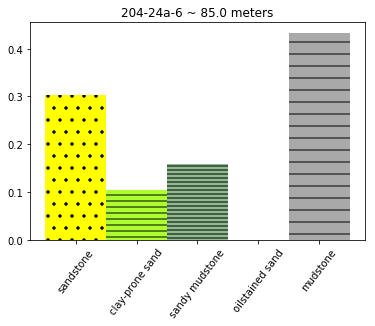

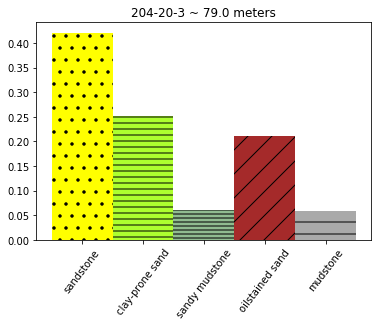

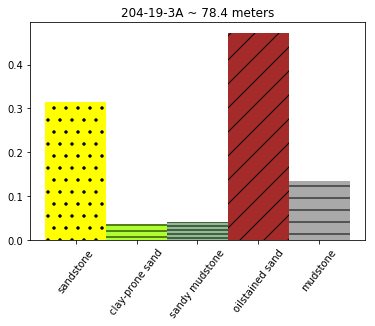

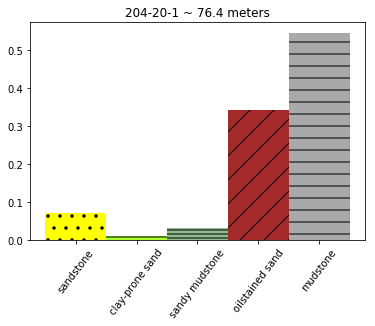

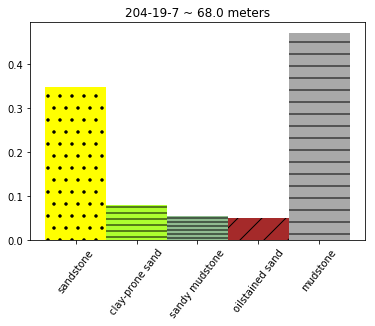

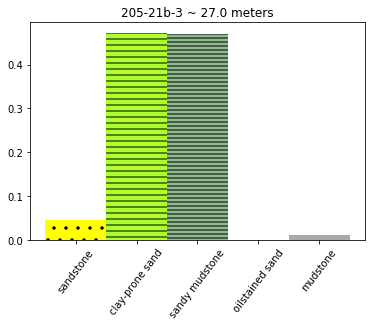

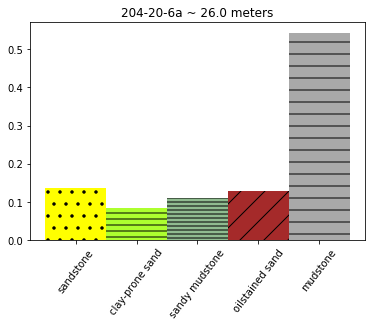

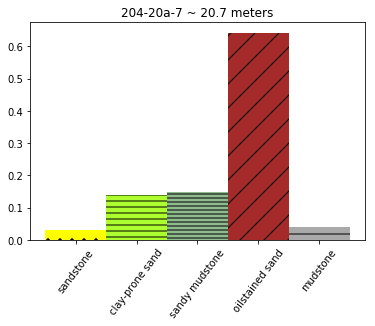

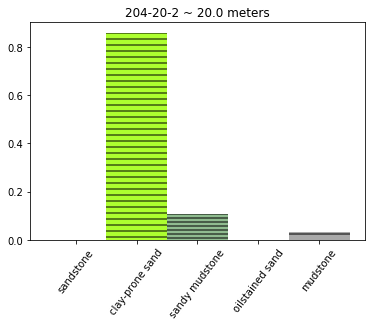

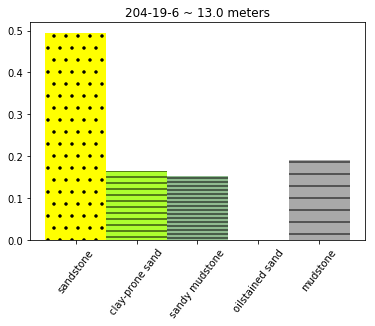

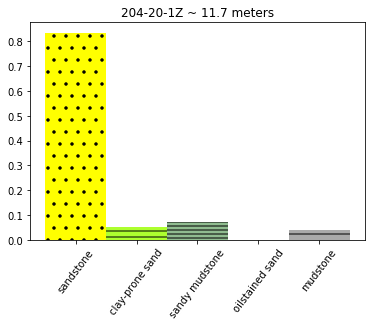

In [34]:
all_labels = []

for well_name in well_names:
    labels = get_labels_array(well_name)
    all_labels.append(labels)
    
    n, bins, patches = plt.hist(labels[np.where(labels>1)], normed=True, bins=np.arange(1.5, 7.5, 1.0))
    
    for p, clr, htch in zip(patches, label_colors, label_hatches):
        p.set_facecolor(clr)
        p.set_hatch(htch)
    
    plt.title(well_name + f' ~ {np.round(get_total_depth(well_name), 1)} meters')
    plt.xticks(ticks=[2,3,4,5,6], labels=label_full_names, rotation=52.5)
    plt.show()

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


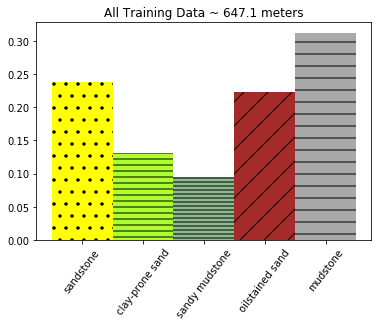

In [37]:
labels = np.concatenate(all_labels)
n, bins, patches = plt.hist(labels[np.where(labels>1)], normed=True, bins=np.arange(1.5, 7.5, 1.0))
    
for p, clr, htch in zip(patches, label_colors, label_hatches):
    p.set_facecolor(clr)
    p.set_hatch(htch)
    
plt.title(f'All Training Data ~ {np.round(total_depth, 1)} meters')
plt.xticks(ticks=[2,3,4,5,6], labels=label_full_names, rotation=52.5)
plt.show()

## Figure out some splits

In [43]:
well_label_counts = {w : np.bincount(get_labels_array(w))[2:] for w in well_names}
well_label_counts

{'204-24a-7': array([ 84550,  34849,  41698, 214511, 241803]),
 '204-24a-6': array([125984,  43481,  66309,      0, 180481]),
 '204-20-3': array([146965,  87693,  21075,  73313,  20214]),
 '204-19-3A': array([ 96688,  11360,  12697, 145044,  41041]),
 '204-20-1': array([ 25563,   3138,  11086, 122658, 196107]),
 '204-19-7': array([108686,  25038,  16782,  15765, 147728]),
 '205-21b-3': array([ 5602, 58127, 57856,     0,  1370]),
 '204-20-6a': array([15420,  9315, 12342, 14646, 61644]),
 '204-20a-7': array([ 3020, 13679, 14846, 63804,  3949]),
 '204-20-2': array([    0, 80774,  9986,     0,  3207]),
 '204-19-6': array([29852,  9865,  9134,     0, 11471]),
 '204-20-1Z': array([51216,  3266,  4508,     0,  2384])}

In [52]:
np.sum([well_label_counts[w] for w in ['204-20-1', '204-24a-7']], axis=0)

array([110113,  37987,  52784, 337169, 437910])

In [65]:
def train_test_divergence(train_wells):
    train_props = np.sum([well_label_counts[w] for w in train_wells], axis=0)
    train_props = train_props / train_props.sum()
    
    test_props = np.sum([well_label_counts[w] for w in well_names if w not in train_wells], axis=0)
    test_props = test_props / test_props.sum()
    
    return stats.entropy(train_props, test_props)

In [67]:
# Three train wells
combs_3 = itertools.combinations(well_names, 3)

combs_3_diffs = [(c, train_test_divergence(c)) for c in combs_3]

list(sorted(combs_3_diffs, key=lambda t: t[1]))

[(('204-24a-7', '204-24a-6', '204-20-3'), 0.006945600487239023),
 (('204-19-3A', '204-19-7', '205-21b-3'), 0.02210503697590649),
 (('204-20-3', '204-20-1', '204-19-6'), 0.02548058776761601),
 (('204-20-3', '204-20-1', '204-20-6a'), 0.02610291005776716),
 (('204-24a-6', '204-20-3', '204-20-1'), 0.02724080800547163),
 (('204-24a-7', '204-20-3', '204-19-7'), 0.027556230551798084),
 (('204-20-6a', '204-20a-7', '204-20-1Z'), 0.028110100912067115),
 (('204-19-7', '204-20a-7', '204-19-6'), 0.02826029225312405),
 (('204-24a-6', '204-19-3A', '204-20-2'), 0.02929849146510062),
 (('204-24a-7', '204-20-3', '204-20-6a'), 0.029619453263606748),
 (('204-20-3', '204-20-1', '205-21b-3'), 0.030441865342208205),
 (('204-20-6a', '204-20a-7', '204-19-6'), 0.031428327366895506),
 (('204-24a-7', '204-19-7', '205-21b-3'), 0.03216276021738124),
 (('204-24a-6', '204-19-3A', '204-20a-7'), 0.03500586293287365),
 (('204-24a-7', '204-20-3', '204-19-6'), 0.03557794392409881),
 (('204-24a-7', '205-21b-3', '204-20-1Z'

In [71]:
train_sets_3 = [
    ['204-24a-7', '204-24a-6', '204-20-3'],
    ['204-19-3A', '204-19-7', '205-21b-3'],
    ['204-20-1', '204-20-2', '204-19-6']
]

In [68]:
# Six train wells
combs_6 = itertools.combinations(well_names, 6)

combs_6_diffs = [(c, train_test_divergence(c)) for c in combs_6]

list(sorted(combs_6_diffs, key=lambda t: t[1]))

[(('204-24a-7', '204-24a-6', '204-20-3', '204-20-6a', '204-20a-7', '204-19-6'),
  0.0033420265352706686),
 (('204-19-3A', '204-20-1', '204-19-7', '205-21b-3', '204-20-2', '204-20-1Z'),
  0.003448886663840627),
 (('204-24a-7', '204-24a-6', '204-19-3A', '204-20-2', '204-19-6', '204-20-1Z'),
  0.005003176258721985),
 (('204-20-3', '204-20-1', '204-19-7', '205-21b-3', '204-20-6a', '204-20a-7'),
  0.005140181954835156),
 (('204-24a-7',
   '204-24a-6',
   '204-20-3',
   '204-20-6a',
   '204-20a-7',
   '204-20-1Z'),
  0.009063841895582144),
 (('204-24a-7', '204-19-7', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z'),
  0.009117763817328099),
 (('204-19-3A', '204-20-1', '204-19-7', '205-21b-3', '204-20-2', '204-19-6'),
  0.009141409698747664),
 (('204-24a-7',
   '204-24a-6',
   '204-19-3A',
   '204-20-6a',
   '204-20-2',
   '204-20-1Z'),
  0.009232240203036715),
 (('204-24a-7', '204-20-3', '204-19-7', '205-21b-3', '204-20-6a', '204-19-6'),
  0.009286173328642554),
 (('204-24a-6', '204-19-3A',

In [72]:
train_sets_6 = [
    ['204-24a-7', '204-24a-6', '204-20-3', '204-20-6a', '204-20a-7', '204-19-6'],
    ['204-19-3A', '204-20-1', '204-19-7', '205-21b-3', '204-20-2', '204-20-1Z'],
    ['204-20-3', '204-20-1', '204-19-7', '205-21b-3', '204-20-6a', '204-20a-7']
]

In [69]:
# Nine train wells
combs_9 = itertools.combinations(well_names, 9)

combs_9_diffs = [(c, train_test_difference(c)) for c in combs_9]

list(sorted(combs_9_diffs, key=lambda t: t[1]))

[(('204-19-3A',
   '204-20-1',
   '204-19-7',
   '205-21b-3',
   '204-20-6a',
   '204-20a-7',
   '204-20-2',
   '204-19-6',
   '204-20-1Z'),
  0.1051996890632869),
 (('204-24a-7',
   '204-24a-6',
   '204-19-3A',
   '204-19-7',
   '205-21b-3',
   '204-20-6a',
   '204-20a-7',
   '204-20-2',
   '204-20-1Z'),
  0.1575896058017558),
 (('204-24a-7',
   '204-24a-6',
   '204-19-3A',
   '204-19-7',
   '205-21b-3',
   '204-20a-7',
   '204-20-2',
   '204-19-6',
   '204-20-1Z'),
  0.164763849115514),
 (('204-24a-6',
   '204-19-3A',
   '204-20-1',
   '205-21b-3',
   '204-20-6a',
   '204-20a-7',
   '204-20-2',
   '204-19-6',
   '204-20-1Z'),
  0.1741177936675003),
 (('204-24a-7',
   '204-24a-6',
   '204-20-3',
   '204-20-1',
   '204-20-6a',
   '204-20a-7',
   '204-20-2',
   '204-19-6',
   '204-20-1Z'),
  0.18130157021342336),
 (('204-24a-6',
   '204-19-3A',
   '204-20-1',
   '204-19-7',
   '205-21b-3',
   '204-20a-7',
   '204-20-2',
   '204-19-6',
   '204-20-1Z'),
  0.18131401117057833),
 (('204-24a

In [75]:
train_sets_9 = [
    ['204-19-3A','204-20-1','204-19-7','205-21b-3','204-20-6a','204-20a-7','204-20-2','204-19-6','204-20-1Z'],
    ['204-24a-7','204-24a-6','204-19-3A','204-19-7','205-21b-3','204-20-6a','204-20a-7','204-20-2','204-20-1Z'],
    ['204-24a-7','204-24a-6','204-20-3','204-20-1','204-20-6a','204-20a-7','204-20-2','204-19-6','204-20-1Z']
]

('204-19-3A', '204-20-1', '204-19-7', '205-21b-3', '204-20-6a', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [0, 2]
('204-24a-7', '204-24a-6', '204-19-3A', '204-19-7', '205-21b-3', '204-20-6a', '204-20a-7', '204-20-2', '204-20-1Z') [2, 0]
('204-24a-7', '204-24a-6', '204-19-3A', '204-19-7', '205-21b-3', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [2, 1]
('204-24a-6', '204-19-3A', '204-20-1', '205-21b-3', '204-20-6a', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [1, 2]
('204-24a-7', '204-24a-6', '204-20-3', '204-20-1', '204-20-6a', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [3, 3]
('204-24a-6', '204-19-3A', '204-20-1', '204-19-7', '205-21b-3', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [1, 2]
('204-24a-7', '204-24a-6', '204-19-3A', '204-19-7', '204-20-6a', '204-20a-7', '204-20-2', '204-19-6', '204-20-1Z') [2, 1]
('204-24a-6', '204-20-3', '204-19-3A', '204-20-1', '204-19-7', '204-20-6a', '204-20a-7', '204-20-2', '204-19-6') [2, 3]
('204-24a-7', '204-24a-6', '

In [ ]:
for comb, div in list(sorted(combs_9_diffs, key=lambda t: t[1])):
    dists = [len(set(comb).difference(ts)) for ts in train_sets_9]
    print(comb, dists)